In [2]:
# Mount Google Drive safely
from google.colab import drive
import os
import shutil

mount_path = '/content/drive'

# If already mounted, unmount it first
if os.path.ismount(mount_path):
    drive.flush_and_unmount()

# Just in case the folder still exists in Colab's local storage, remove it
if os.path.exists(mount_path):
    shutil.rmtree(mount_path)

# Now mount fresh
drive.mount(mount_path, force_remount=True)


Mounted at /content/drive


In [3]:
!pip install tensorflow --upgrade --quiet

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize grayscale to 0–1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Train/Validation split
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train: (50000, 28, 28), Val: (10000, 28, 28), Test: (10000, 28, 28)


In [5]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 64

def preprocess(image, label):
    # Convert grayscale (28x28) → RGB (96x96)
    image = tf.expand_dims(image, axis=-1)  # shape (28,28,1)
    image = tf.image.grayscale_to_rgb(image) # shape (28,28,3)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

# Create tf.data pipelines
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .shuffle(1000) \
            .batch(BATCH_SIZE) \
            .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(BATCH_SIZE) \
            .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(BATCH_SIZE) \
            .prefetch(tf.data.AUTOTUNE)


In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base layers
base_model.trainable = False

# Add classification head
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_tl = tf.keras.Model(inputs, outputs)

model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.8583 - loss: 0.4771 - val_accuracy: 0.9587 - val_loss: 0.1299
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9643 - loss: 0.1166 - val_accuracy: 0.9693 - val_loss: 0.0956
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9712 - loss: 0.0900 - val_accuracy: 0.9702 - val_loss: 0.0903


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9644 - loss: 0.1057
Test Accuracy: 0.9716
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.93      0.97      0.95      1032
           3       0.95      0.94      0.95      1010
           4       0.99      0.96      0.98       982
           5       0.95      0.92      0.93       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



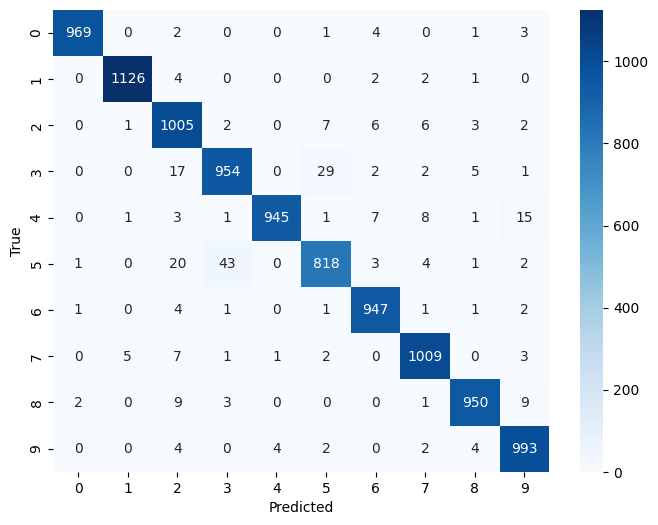

Model saved to: /content/drive/MyDrive/mnist_mobilenetv2_tl.keras


In [8]:
# Evaluate
test_loss, test_acc = model_tl.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(model_tl.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save model
save_path = '/content/drive/MyDrive/mnist_mobilenetv2_tl.keras'
model_tl.save(save_path)
print(f"Model saved to: {save_path}")


In [9]:
from google.colab import files
from PIL import Image

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    # Load the image
    img = Image.open(filename).convert("L")  # convert to grayscale
    img = img.resize((28, 28))  # MNIST original size

    # Convert to array & normalize
    img_array = np.array(img).astype("float32") / 255.0

    # Convert grayscale to RGB & resize to MobileNetV2 input size
    img_array = tf.expand_dims(img_array, axis=-1)       # shape (28,28,1)
    img_array = tf.image.grayscale_to_rgb(img_array)     # shape (28,28,3)
    img_array = tf.image.resize(img_array, IMG_SIZE)     # shape (96,96,3)
    img_array = tf.expand_dims(img_array, axis=0)        # shape (1,96,96,3)

    # Prediction
    prediction = model_tl.predict(img_array)
    predicted_label = np.argmax(prediction)

    print(f"Predicted Digit: {predicted_label}")


Saving sample image.png to sample image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Digit: 9


In [10]:
from tensorflow import keras

# Path to your saved model in Drive
load_path = '/content/drive/MyDrive/mnist_mobilenetv2_tl.keras'

# Load the model
model_tl = keras.models.load_model(load_path)

print("✅ Model loaded successfully!")
model_tl.summary()


✅ Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,296,416 (8.76 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 25,622 (100.09 KB)

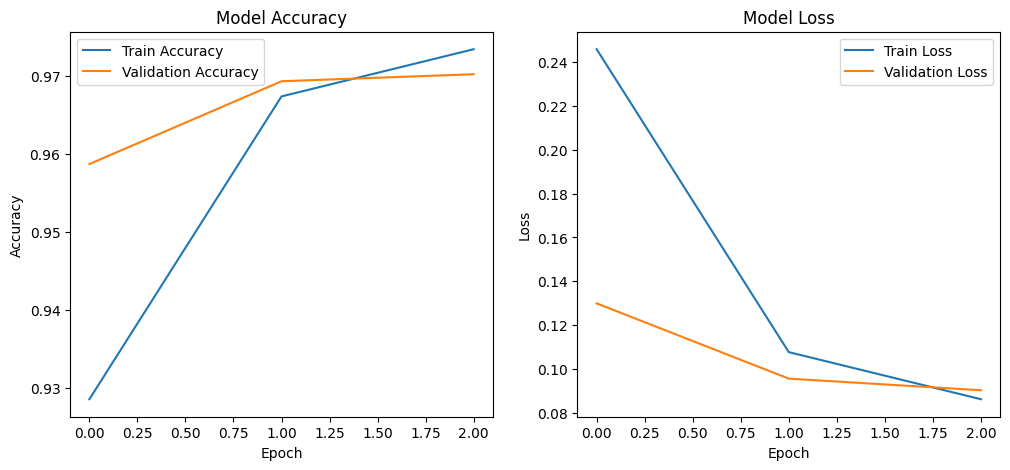

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step


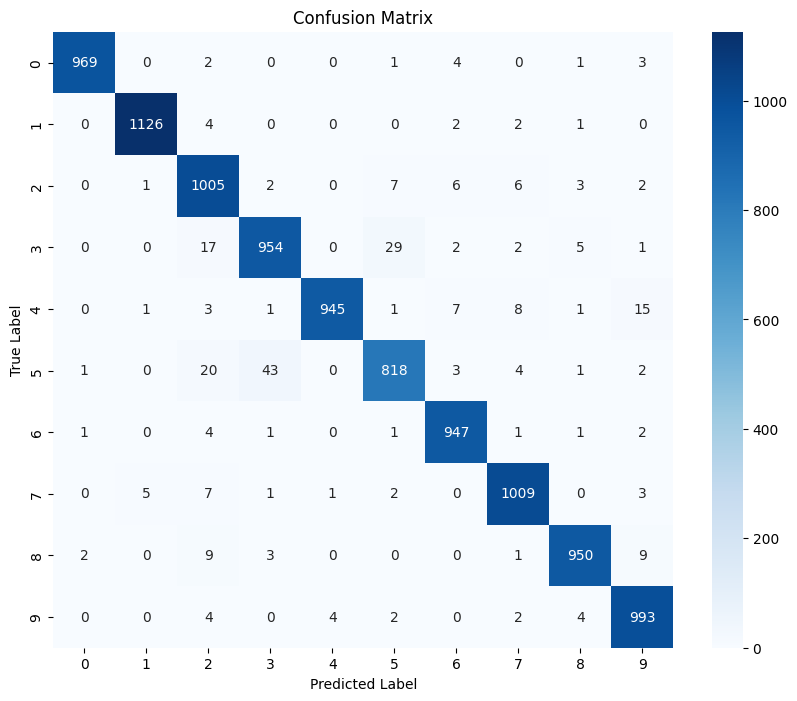

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Recreate test dataset (MNIST) with same preprocessing as training
(_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test.astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1)  # shape (28,28,1)
x_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_test))
IMG_SIZE = (96, 96)
x_test_resized = tf.image.resize(x_test_rgb, IMG_SIZE)

# Create tf.data.Dataset
test_ds_tl = tf.data.Dataset.from_tensor_slices((x_test_resized, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Get predictions
y_pred_probs = model_tl.predict(test_ds_tl)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


✅ Test Accuracy: 97.16%


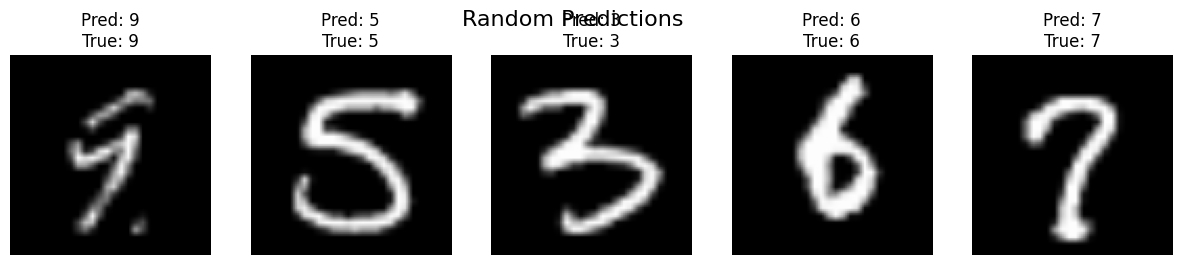

In [13]:
import random

# Evaluate model on test set
loss, accuracy = model_tl.evaluate(test_ds_tl, verbose=0)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

# Pick 5 random indices from the test set
random_indices = random.sample(range(len(x_test)), 5)

plt.figure(figsize=(15,3))
for i, idx in enumerate(random_indices):
    img = x_test_resized[idx].numpy()
    true_label = y_test[idx]

    # Model expects batch dimension
    pred_prob = model_tl.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = np.argmax(pred_prob)

    plt.subplot(1,5,i+1)
    plt.imshow(img.astype("float32"))
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis('off')

plt.suptitle("Random Predictions", fontsize=16)
plt.show()


In [14]:
import os
OUT = '/content/drive/MyDrive/vision_mnist_project'
os.makedirs(OUT, exist_ok=True)


In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUT, 'confusion_matrix.png'), bbox_inches='tight')
plt.close()


In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.savefig(os.path.join(OUT,'training_curves.png'), bbox_inches='tight')
plt.close()


In [17]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, digits=4)
with open(os.path.join(OUT,'classification_report.txt'),'w') as f:
    f.write(report)
print("Saved classification_report.txt")


Saved classification_report.txt


In [18]:
# Create 12 example images with predicted + true labels (use test images)
sample_folder = os.path.join(OUT,'sample_preds'); os.makedirs(sample_folder, exist_ok=True)
for i in range(12):
    img = x_test_resized[i].numpy()  # or original resized image
    plt.imshow(img)
    plt.title(f"Pred:{y_pred[i]} True:{y_test[i]}")
    plt.axis('off')
    plt.savefig(os.path.join(sample_folder, f'sample_{i}.png'), bbox_inches='tight', pad_inches=0)
    plt.close()


In [19]:
model_path = os.path.join(OUT, 'mnist_mobilenetv2_finetuned.keras')
model_tl.save(model_path)
print("Model saved to:", model_path)


Model saved to: /content/drive/MyDrive/vision_mnist_project/mnist_mobilenetv2_finetuned.keras
